In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import random_split
from torch.nn.functional import relu
import warnings
import cv2
import matplotlib.pyplot as plt
import json
from PIL import Image
# from shapely.geometry import Polygon, MultiPolygon
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
# from skimage import draw
# from tqdm import tqdm

warnings.filterwarnings("ignore", category=UserWarning)

Отображение bbox на изображении

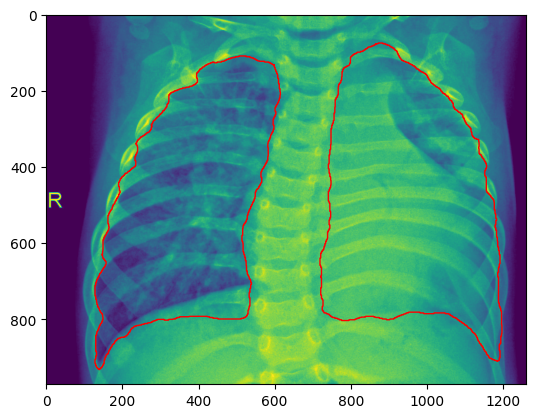

In [2]:
file_path = '../data/all-images/annotations/person802_bacteria_2708.json'  
with open(file_path, 'r') as json_file:
    data = json.load(json_file)

left_lung_x_coordinates = [point['x'] for point in data['annotations'][0]['polygon']['path']]
left_lung_y_coordinates = [point['y'] for point in data['annotations'][0]['polygon']['path']]

right_lung_x_coordinates = [point['x'] for point in data['annotations'][1]['polygon']['path']]
right_lung_y_coordinates = [point['y'] for point in data['annotations'][1]['polygon']['path']]

left_polygon = Polygon(zip(left_lung_x_coordinates, left_lung_y_coordinates))
right_polygon = Polygon(zip(right_lung_x_coordinates, right_lung_y_coordinates))


img = cv2.imread('../data/images/person802_bacteria_2708.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray)
x, y = left_polygon.exterior.xy
plt.plot(x, y, color='r', linewidth=1)


x, y = right_polygon.exterior.xy
plt.plot(x, y, color='r', linewidth=1)

Разобраться:
1) Разобраться в def forward
2) class Up(bilinear, ConvTranspose2d, def forward)
3) class Unet(nn.ModuleList, def forward)

<span style="font-size:20px;">Модель U-Net с [GitHub]((https://github.com/annikabrundyn/unet_segmentation/blob/main/unet.py#L6]))</span> 

In [11]:
class DoubleConvolution(nn.Module):
    """
    [ Conv2d => BatchNorm (optional) => ReLU ] x 2
    """
    def __init__(self, input_channel, output_channel):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x) 


class Down(nn.Module):
    """
    Downscale with MaxPool => DoubleConvolution block
    """
    def __init__(self, input_channel, output_channel):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConvolution(input_channel, output_channel)
        )

    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    """
    Upsampling (by either bilinear interpolation or transpose convolutions)
    followed by concatenation of feature map from contracting path,
    followed by DoubleConv.
    """
    def __init__(self, input_channel, output_channel, bilinear=False):
        super().__init__()
        self.upsample = None
        if bilinear:
            self.upsample = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                nn.Conv2d(input_channel, input_channel // 2, kernel_size=1),
            )
        else:
            self.upsample = nn.ConvTranspose2d(input_channel, input_channel // 2, kernel_size=2, stride=2)

        self.conv = DoubleConvolution(input_channel, output_channel)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)

        # Pad x1 to the size of x2
        diff_h = x2.shape[2] - x1.shape[2]
        diff_w = x2.shape[3] - x1.shape[3]

        x1 = F.pad(x1, [diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2])

        # Concatenate along the channels axis
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Unet(pl.LightningModule):
    def __init__(self, num_classes, num_layers=5, features_start=64, bilinear=False):
        super().__init__()
        self.num_layers = num_layers
        layers = [DoubleConvolution(3, features_start)]
        for _ in range(num_layers - 1):
            layers.append(Down(features_start, features_start * 2))
            features_start *= 2
        for _ in range(num_layers - 1):
            layers.append(Up(features_start, features_start // 2, bilinear))
            features_start //= 2
        layers.append(nn.Conv2d(features_start, num_classes, kernel_size=1))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        xi = [self.layers[0](x)]
        # Down path
        for layer in self.layers[1:self.num_layers]:
            xi.append(layer(xi[-1]))
        # Up path
        for i, layer in enumerate(self.layers[self.num_layers:-1]):
            xi[-1] = layer(xi[-1], xi[-2 - i])
        return self.layers[-1](xi[-1])
        
    def training_step(self, train_batch, batch_idx):
      images, labels = train_batch
      # images = images.reshape(-1, 572)
      outputs = self.forward(images)
      loss = self.cross_entropy_loss(outputs, labels)
      self.log('train_loss', loss)
      return {'loss': loss}

    def validation_step(self, val_batch, batch_idx):
      images, labels = val_batch
      logits = self.forward(x)
      loss = self.cross_entropy_loss(logits, y)
      self.log('val_loss', loss)

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
      return optimizer
        
    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

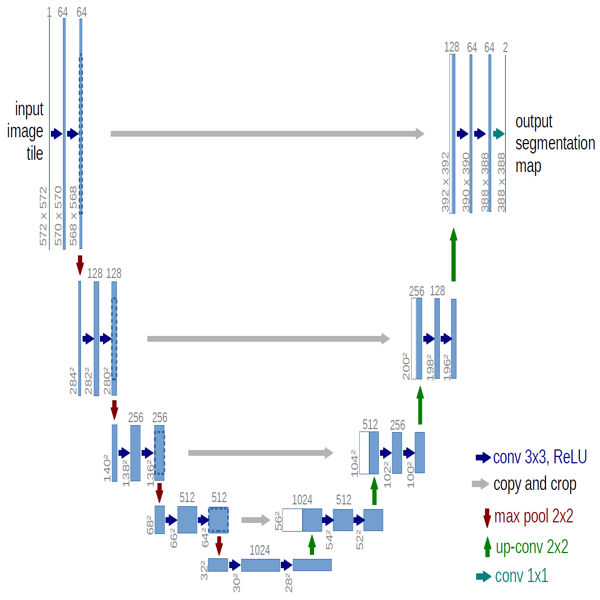

In [61]:
path_to_image = '../data/u-net-architecture.png'
new_size = (600, 600)  # Измените размеры по вашему усмотрению
original_image = Image.open(path_to_image)
resized_image = original_image.resize(new_size)
display(resized_image)

<span style="font-size:20px;">Архитектура U-Net </span> 

In short, data preparation has 4 steps:
1. Download image(Мне нужны только снимки и аннотации), исключить боковые снимки, которые не имеют сегментированные легкие в JSON файлеs3
2. Image transforms (these are highly subjective - все привести к одному размеру)4
3. Generate training, validation and test dataset split5.
4. Wrap each dataset split in a DataLo
   
https://www.youtube.com/watch?v=PXOzkkB5eH0&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=9


https://www.youtube.com/watch?v=Hgg8Xy6IRig&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=21 - pl.Dataloader and pl.Dataset

 - использует только 1 batch для тренировки(используется для тесder

Оставляем только маски и изображения с сегментированными легкими 'name'= 'Lung'

Удаленные маски:
1) Снимки КТ, 'name' = 'CT'
2) Боковые рентгеновские снимки, 'name' = 'X-Ray'
3) Снимки с несколькими разметками

In [4]:
annotations_path = '../data/all-images/annotations/'
images_path = '../data/images'
lung_annotations_filename = []
lung_images_filename = []
annotations = os.listdir(annotations_path)
for ann in annotations:
    with open(annotations_path + ann, 'r') as json_file:
        data = json.load(json_file)
    if 'Lung' in data['annotations'][0]['name'] and 'Lung' in data['annotations'][1]['name'] :
        lung_annotations_filename.append(ann)
        lung_images_filename.append(data['image']['original_filename'])
        
print(f'Кол-во подходящих снимков - {len(lung_annotations_filename)} из {len(annotations)}')

Кол-во подходящих снимков - 6365 из 6365


In [16]:
def delete_extra_files():
    """
    Delete files with inappropriate format
    """
    img_path = '../data/images/'
    images_names = os.listdir(img_path)
    print(f'Начальное число изображений - {len(images_names)}')
    for name in images_names:
        if name not in lung_images_filename:
            full_path = os.path.join(img_path, name)
            os.remove(full_path) 
    
    print(f'Конечное число изображений - {len(images_names)}')
    
    ann_path = '../data/all-images/annotations/'
    annotations_names = os.listdir(ann_path)
    print(f'Начальное число json файлов - {len(annotations_names)}')
    for name in annotations_names:
        if name not in lung_annotations_filename:
            full_path = os.path.join(ann_path, name)
            os.remove(full_path)
            
    images_name = [img.split('.')[0] for img in lung_images_filename]
    images_format = [img.split('.')[1] for img in lung_images_filename]
    ann_name = [ann.split('.')[0] for ann in lung_annotations_filename]
    extra_images = set(images_name)  - set(ann_name)
    for name in extra_images:
        images = []
        if name in lung_images_filename:
            images.append(file_name)
        images_format = [img.split('.')[1] for img in images]
        file_name = name.split('.')[0] + '.json'
        full_path = os.path.join(img_path, name)
        os.remove(full_path)
    
    print(f'Конечное число json файлов - {len(os.listdir(ann_path))}')

delete_extra_files()

Начальное число изображений - 6365
Конечное число изображений - 6365
Начальное число json файлов - 6365
Конечное число json файлов - 6365


Класс для обработки сегментаций

In [40]:
class get_DataSet(Dataset):
    """
    class for preparing annotations
    """
    def __init__(self, path_to_imgs, path_to_json, X_shape):
        self.path_to_imgs = path_to_imgs
        self.path_to_json = path_to_json
        self.img_ids = os.listdir(path_to_imgs)
        self.X_shape = X_shape
    
    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        img_id = os.path.splitext(image_name)[0]
        img_format = os.path.splitext(self.img_ids[idx])[1]
        img = cv2.imread(os.path.join(self.path_to_imgs, img_id + img_format))
        load_json = json.load(open(os.path.join(self.path_to_json, img_id + ".json")))
        left_lung = [[point['x'], point['y']] for point in load_json['annotations'][0]['polygon']['path']]
        right_lung = [[point['x'], point['y']] for point in load_json['annotations'][1]['polygon']['path']]
        lungs = {'left_lung': left_lung,
                 'right_lung': right_lung}
        img, annotations = self.transform(img, lungs)
        return img, annotations, image_name

    def __len__(self):
        return len(self.img_ids)
    
    def transform(self, image, lungs):
        resized_img = cv2.resize(image, (self.X_shape, self.X_shape))[:,:,0]  #grayscale version 
        scale_x = self.X_shape / image.shape[1]
        scale_y = self.X_shape / image.shape[0]
        lungs['left_lung'] = [(x * scale_x, y * scale_y) for x, y in lungs['left_lung']]
        lungs['right_lung'] = [(x * scale_x, y * scale_y) for x, y in lungs['right_lung']]    
        return resized_img, lungs

In [132]:
image_path = '../data/images/'
annotations_path = '../data/all-images/annotations/'
dataset = get_DataSet(image_path, annotations_path, X_shape = 572)

def save_masks():
    for num in range(len(dataset)):
        img, lungs, img_name = dataset[num]
        left_polygon = lungs['left_lung']
        right_polygon = lungs['right_lung']
        left_mask = draw.polygon2mask(img.shape, left_polygon)
        right_mask = draw.polygon2mask(img.shape, right_polygon)
        combined_mask = left_mask + right_mask
        mirrored_mask = np.fliplr(combined_mask)
        rotated_mask = np.rot90(mirrored_mask, k=1)
        rotated_mask = rotated_mask.copy()
        rotated_np_arr  = np.array(rotated_mask,  dtype="uint8")
        binary_image = rotated_np_arr * 255
        cv2.imwrite(f'../data/generated/masks/mask_{img_name}', binary_image)

save_masks()

Создаем Датафрейм с путями до изображений и масок

In [24]:
img_folder = '../data/generated/resized_images'
mask_folder = '../data/generated/masks'
image_paths = []
mask_paths = []

for img_name, mask_name in zip(os.listdir(img_folder), os.listdir(mask_folder)):
    image_path = os.path.join(img_folder, img_name)
    image_paths.append(image_path)
    mask_path = os.path.join(mask_folder, mask_name)
    mask_paths.append(mask_path)

full_df = pd.DataFrame({'image_path': image_paths,
                  'mask_path' : mask_paths})
full_df.to_csv('../data/generated/dataset.csv')

Разделяем на train/test/validation и сохраняем отдельными файлами 

In [39]:
objects = df['image_path']
labels = df['mask_path']
x, x_test, y, y_test = train_test_split(objects, labels, test_size=0.2, train_size=0.8, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25, train_size =0.75, random_state=42)
train_df = pd.DataFrame({'object' : x,
                         'label' : y})
train_df.to_csv('../data/generated/train_df.csv', index=False)

test_df = pd.DataFrame({'object' : x_test,
                         'label' : y_test})
test_df.to_csv('../data/generated/test_df.csv', index=False)

val_df = pd.DataFrame({'object' : x_val,
                         'label' : y_val})
val_df.to_csv('../data/generated/val_df.csv', index=False)

DataLoader применяем после того как сформировали train/test dataset
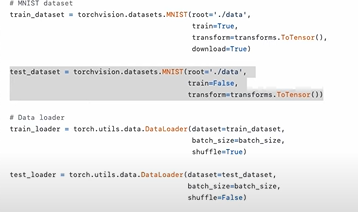

In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  
        mask_path = self.dataframe.iloc[idx, 1] 

        img = Image.open(str(img_path)).convert('RGB')
        # img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)  
        mask = Image.open(str(mask_path)).convert('L')

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

class UnetDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose([transforms.Resize((576, 576)), transforms.ToTensor()])
        self.batch_size = 4
    
    def setup(self, stage: str):
        if stage == "fit" or stage is None:
            train_df = pd.read_csv(self.data_dir + 'train_df.csv')
            self.train_dataset = CustomDataset(train_df, transform=self.transform)
            validation_df = pd.read_csv(self.data_dir + 'val_df.csv')
            self.validation_dataset = CustomDataset(validation_df, transform=self.transform)
        if stage == "test":
            test_df = pd.read_csv(self.data_dir + 'test_df.csv')
            self.test_dataset = CustomDataset(test_df, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)
        
    def val_dataloader(self):
        return DataLoader(self.validation_dataset, batch_size=self.batch_size)
        
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [5]:
class UNet(pl.LightningModule):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # input_image_shape: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input_image_shape: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input_image_shape: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input_image_shape: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input_image_shape: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        return out
    
    def training_step(self, train_batch, batch_idx):
      images, labels = train_batch
      outputs = self(images)
      loss = self.cross_entropy_loss(outputs, labels)
      self.log('train_loss', loss)
      return {'loss': loss}

    def validation_step(self, val_batch, batch_idx):
      images, labels = val_batch
      logits = self.forward(x)
      loss = self.cross_entropy_loss(logits, y)
      self.log('val_loss', loss)

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
      return optimizer
        
    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

Построение модели

In [6]:
data_module = UnetDataModule(data_dir = '../data/generated/')
data_module.setup(stage='fit')
model = UNet(1)
trainer = pl.Trainer(accelerator="gpu", fast_dev_run=True)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
You are using a CUDA device ('NVIDIA RTX A4000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type            | Params
---------------------------------------------
0  | e11     | Conv2d          | 1.8 K 
1  | e12     | Conv2d          | 36.9 K
2  | pool1   | MaxPool2d       | 0     
3  | e21     | Conv2d          | 73.9 K
4  | e22     | Conv2d          | 147 K 
5  | pool2   | MaxPool2d       

Training: |                                                                                      | 0/? [00:00<…

RuntimeError: shape '[4, 576]' is invalid for input of size 1327104

In [3]:
torch.cuda.empty_cache()
device = torch.device("cuda:0")
    # Получите доступное свободное место на выбранном устройстве
free_memory = torch.cuda.get_device_properties(device).total_memory - torch.cuda.memory_allocated(device)
free_memory

8589410304

In [16]:
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(device)
    print(gpu_name)

NVIDIA RTX A4000 Laptop GPU
